In [1]:
import biom
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import qiime2 as q2

from gemelli.factorization import TenAls
from gemelli.preprocessing import build

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from scipy import interp
from skbio import TreeNode
from biom import load_table, Table

from featlib import Sculptor, load_mf
from featlib.extractor import abs_energy
pd.options.mode.chained_assignment = None  # default='warn'

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# rarefy before renaming
bt_rar = load_table('jansson/otu-table.even4000.biom')
bt = load_table('jansson/unrareif/reference-hit.biom')

#mf = load_mf('jansson/mapping-file.txt')
mf = pd.read_csv('jansson/unrareif/1629_20180101-113841.txt',sep='\t',index_col=0)

# we only keep the samples that have sequences in the table
# we will use both ids so that the number matches
# the previous study, even though we did not rarefy here
mf = mf.loc[set(bt.ids()) & set(bt_rar.ids())].copy()

tree = TreeNode.read('gg-tree/97_otus.tree')


In [3]:
samples_to_keep = mf[mf.ibd_subtype.isin(['HC', 'CCD'])].index.tolist()

mf = mf.loc[samples_to_keep].copy()
bt = bt.filter(samples_to_keep, inplace=False)

mf['timepoint'] = pd.to_numeric(mf['timepoint'], errors='coerce')

mf['IBD'] = mf['ibd_subtype'].replace({'CCD': "Crohns",
                                       'HC': 'Control'})
mf['HOST_SUBJECT_ID'] = mf['host_subject_id'].copy()
mf_rar = mf.copy()

# save biom to dataframe
bt_df = bt.to_dataframe().T.to_dense()


In [4]:
from collections import Counter

# here we make sure there are no
# repeated timepoints and sum those
# subids if they exsist.
sid = {x:[] for x in set(mf.HOST_SUBJECT_ID)}
for i,j in zip(mf.HOST_SUBJECT_ID,mf.timepoint):
    sid[i].append(j)
repeated = [[k,k2] for k,v in sid.items()
            for k2,v2 in Counter(v).items()
            if v2 > 1]
for id_,t_ in repeated:
    mf_rep = mf[mf.HOST_SUBJECT_ID.isin([id_]) \
                & mf.timepoint.isin([t_])]
    # keep this one index sum and delete others
    kp = mf_rep.index[0]
    rm = mf_rep.index[1:]
    # sum table
    bt_df.loc[kp,:] = bt_df.loc[mf_rep.index,:].sum(axis=0)
    # drop others 
    bt_df = bt_df.drop(rm)
    mf = mf.drop(rm)
    
    
# now we will remove any subjects
# with only one timepoint
mf = mf[~mf.HOST_SUBJECT_ID.isin([k for k,v in sid.items()
                                  if len(v)<=3])]
bt_df = bt_df.loc[set(mf.index) & set(bt_df.index),:]
# from this we end up with
# slightly less samples
    
# finally make sure no features
# sum to zero after removeing samples
bt_df = bt_df.loc[:,bt_df.sum(axis=0) > 10]
bt_df.shape


(126, 1542)

In [5]:
# Gemelli tensor building
ten_sim = build()
ten_sim.fit(bt_df.copy(), mf.copy(),
            'HOST_SUBJECT_ID', 'timepoint')
# now we have a
# compositional tensor
# with shape:
ten_sim.tensor.shape

(9, 1542, 20)

In [6]:
# factor the tensor
TF_sim = TenAls(rank=2).fit(ten_sim.TRCLR)


In [56]:
# build biplot
import skbio
from qiime2 import Artifact
from q2_types.ordination import PCoAResults
from qiime2.plugin import (Properties, Int)

#save ord file for biplot
rename_cols = {i - 1: 'PC' + str(i) for i in range(1, 3 + 1)}

# Feature Loadings
feature_loading = pd.DataFrame(TF_sim.feature_loading,
                               index=ten_sim.feature_order)
feature_loading = feature_loading.rename(columns=rename_cols)
feature_loading.sort_values('PC1', inplace=True, ascending=True)
feature_loading -= feature_loading.mean(axis=0)
feature_loading['PC3'] = 0.0

# Sample Loadings
sample_loading = pd.DataFrame(TF_sim.sample_loading,
                              index=ten_sim.ID_order)
sample_loading = sample_loading.rename(columns=rename_cols)
sample_loading -= sample_loading.mean(axis=0)
sample_loading['PC3'] = 0.0

# % var explained
proportion_explained = pd.Series(list(TF_sim.eigenvalues / TF_sim.eigenvalues.sum())+[0.0],
                                 index=list(rename_cols.values()))
# get eigenvalues
eigvals = pd.Series(list(TF_sim.eigenvalues)+[0.0],
                    index=list(rename_cols.values()))

# save ordination results
short_method_name = 'tf_biplot'
long_method_name = 'TF-Biplot'
ord_res = skbio.OrdinationResults(
    short_method_name,
    long_method_name,
    eigvals.copy(),
    samples=sample_loading.copy(),
    features=feature_loading.copy(),
    proportion_explained=proportion_explained.copy())

# table matched tree 
q2ord = Artifact.import_data(PCoAResults % Properties("biplot"),ord_res)
q2ord.save('TF_figures/jansson/intermediates/TF_biplot')
# sample map
#delmap = {k:v for k,v in zip(metadata_binned.Id_num,metadata_binned.DeliveryMode)}
#mapping_cond = pd.DataFrame([delmap[i] for i in ten_sim.ID_order],ten_sim.ID_order,['Delivery Mode'])
gmap = {k:x.split('_')[0] for k,x in zip(mf.HOST_SUBJECT_ID,
                                         mf.IBD)}
mapping_cond = pd.DataFrame([gmap[i] for i in ten_sim.ID_order],ten_sim.ID_order,['IBD'])
mapping_cond['IBD'] = [gmap[x] for x in sampload.index]
mapping_cond.index.name = 'sample-id'
mapping_cond.to_csv('TF_figures/jansson/intermediates/biplot_sample_map.tsv',sep='\t')
# taxa map
taxamap = pd.read_csv('jansson/unrareif/taxonomy_out/taxonomy.tsv',sep='\t').set_index('Feature ID')
#taxamap = pd.DataFrame(['; '.join(list(x)) for x in taxamap.values],taxamap.index,['Taxon'])
taxamap.index.name = 'Feature ID'
taxamap.to_csv('TF_figures/jansson/intermediates/biplot_taxa_map.tsv',sep='\t')

!qiime emperor biplot --i-biplot TF_figures/jansson/intermediates/TF_biplot.qza\
                      --m-sample-metadata-file TF_figures/jansson/intermediates/biplot_sample_map.tsv\
                      --m-feature-metadata-file TF_figures/jansson/intermediates/biplot_taxa_map.tsv \
                      --o-visualization TF_figures/jansson/intermediates/biplot_viz.qzv\
                      --p-number-of-features 7


Saved Visualization to: TF_figures/jansson/intermediates/biplot_viz.qzv


In [7]:
# basic viualization of the overall 
# discrimination between IBD/No-IDB
# in the first three PCs
sampload = pd.DataFrame(TF_sim.sample_loading,ten_sim.ID_order)
gmap = {k:x.split('_')[0] for k,x in zip(mf.HOST_SUBJECT_ID,
                                         mf.IBD)}
sampload['IBD'] = [gmap[x] for x in sampload.index]
sampload.head(5)


,0,1,IBD
1629:1,-0.392471,-0.194374,Crohns
1629:141,-0.279559,-0.215317,Crohns
1629:187,-0.267744,-0.210374,Crohns
1629:193,-0.015529,-0.202051,Crohns
1629:288,-0.003545,-0.252074,Crohns


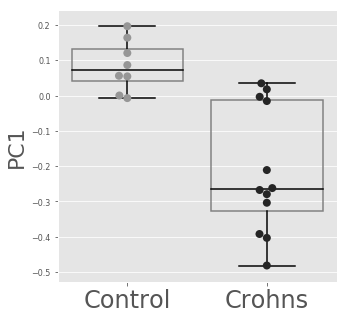

In [70]:

plt.rcParams['xtick.labelsize']=24
plt.rcParams['ytick.labelsize']=8

col_dmap = {'Crohns': '#252525', 'Control': '#969696'}
fig,axn = plt.subplots(1,1,figsize=(5,5))

#for i,ax1 in enumerate(axn.flatten()):
i=0
ax1 = axn

sns.boxplot(x='IBD',y=i,
              data=sampload.sort_values('IBD'),
              ax=ax1,palette=col_dmap)

# remove boxplot colors from:
# https://stackoverflow.com/questions
#/36874697/how-to-edit-properties-of
#-whiskers-fliers-caps-etc-in-seaborn-boxplot
for q,artist in enumerate(ax1.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor('grey')
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(q*6,q*6+6):
        line = ax1.lines[j]
        line.set_color('black')
        line.set_mfc(col)
        line.set_mec(col)

sns.swarmplot(x='IBD',y=i,
              data=sampload.sort_values('IBD'),
              ax=ax1,s=8,palette=col_dmap)
ax1.set_ylabel('PC'+str(i+1),fontsize=22)
ax1.set_xlabel('',fontsize=22)
#+' ('+str(np.around(proportion_explained['PC'+str(i+1)],2)*100)+str(')')
plt.savefig('TF_figures/jansson/roc-curves/PC1.png',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.show()



In [9]:
traj = np.dot(TF_sim.sample_loading[:, :],
              TF_sim.conditional_loading[:, :].T)
traj = pd.DataFrame(traj,ten_sim.ID_order,ten_sim.cond_order)
traj = traj.stack().reset_index()
traj.columns = ['ID','Day','Loading']
traj['IBD'] = [gmap[i] for i in traj.ID]
traj.head(5)


,ID,Day,Loading,IBD
0,1629:1,1,-0.108481,Crohns
1,1629:1,2,-0.076021,Crohns
2,1629:1,3,-0.063243,Crohns
3,1629:1,4,-0.095907,Crohns
4,1629:1,5,-0.077207,Crohns


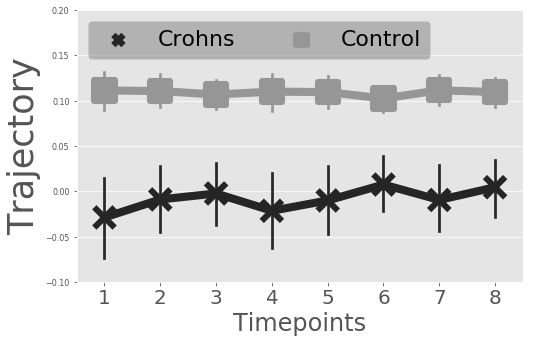

In [71]:
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=8

fig,ax2 = plt.subplots(1,1,figsize=(8,5))
traj_plot = traj[~traj.Day.isin([9])]
sns.pointplot(x='Day',y='Loading',markers=['x','s'],
              hue='IBD',ci=95,scale=3,palette=col_dmap,
              data=traj_plot.sort_values('IBD',ascending=False),ax=ax2)
handles, labels = ax2.get_legend_handles_labels()
legend = ax2.legend(handles[:2], labels[:2],
            prop={'size':22}, loc=2, 
            bbox_to_anchor=(0.0, 1.0),
            fancybox=True, framealpha=0.5,ncol=2
            , markerscale=.5, facecolor="grey")

ax2.set_xlabel('Timepoints',fontsize=24)
#ax2.set_ylabel('Trajectory-PC'+str(PC_view+1),fontsize=35)
ax2.set_ylabel('Trajectory',fontsize=35)
ax2.set_ylim(-.1,.2)

fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)
plt.savefig('TF_figures/jansson/roc-curves/trajectory.png',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.show()

In [103]:
from scipy.spatial import distance
from skbio.stats.distance import permanova
from skbio.stats.distance import DistanceMatrix

tjdist = []
for i in [0]:
    tjdist.append(np.dot(TF_sim.sample_loading[:, [i]],
                         TF_sim.conditional_loading[:, [i]].T).flatten())
tjdist = np.vstack(tjdist)  
tjdist = distance.cdist(tjdist.T,tjdist.T)

delivid = {k:v for k,v in zip(mf.host_subject_id,mf.IBD)}
covariate = [j for i in ten_sim.ID_order 
             for k,j in enumerate([delivid[i]]*TF_sim.conditional_loading.shape[0])]
permTF = permanova(DistanceMatrix(tjdist),covariate)  
permTF


method name               PERMANOVA
test statistic name        pseudo-F
sample size                     180
number of groups                  2
test statistic              141.024
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [91]:
from collections import Counter
Counter(sampload['IBD'])

Counter({'Crohns': 12, 'Control': 8})

In [11]:
# match to be compareable
think = Sculptor(biom_table=bt_rar.filter(mf.index.tolist(), inplace=False),
                 mapping_file=mf, tree=tree,
                 gradient='timepoint', trajectory='host_subject_id',
                 name='gg-jansson')


/anaconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/anaconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


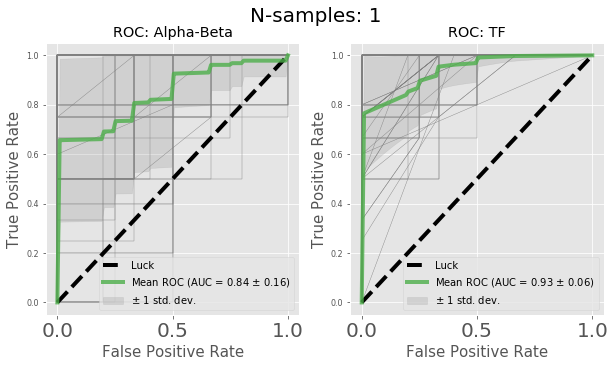

In [13]:
lw = 4
N = 100
for N_samples in range(0, 5):

    fig,axn = plt.subplots(1,2,figsize=(10,5))
    AUCs = {}
    mean_tpr = {}
    method_ = {}
    for i in range(len(axn)):
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr[i] = []
        AUCs[i] = []

    i = 0
    while i < N:
        ## BEGIN feature creation
        
        # zero samples means "traditional" classifier
        # with one sample per subject
        think.randomly_select(1 if N_samples == 0 else N_samples)

        # groups discovered by phylofactor
        features_to_keep = []
        for _, id_, md in think.biom_table.iter(axis='observation', dense=False):
            t = md['taxonomy']
            if (t[4].lower() == 'f__lachnospiraceae'
                or t[2].lower() == 'c__gammaproteobacteria'
                or t[2].lower() == 'c__betaproteobacteria'):
                features_to_keep.append(id_)

        # more than one sample
        if N_samples > 1:
            alpha = think.alpha_table(['faith_pd', 'chao1', 'brillouin_d'])
            beta = think.beta_table()
            features = think.microbes_over_time(ids=features_to_keep)
            
            # combine the data
            combined_features = pd.concat([features, alpha, beta], axis=1)

            # get a column with IBD status for all the subjects
            combined_features.dropna(axis=1, how='any', inplace=True)
            classes = think.mapping_file.groupby(['HOST_SUBJECT_ID', 'IBD'],
                                        as_index=False).aggregate(np.sum).set_index('HOST_SUBJECT_ID',
                                                                                    inplace=False)
            combined_features['IBD'] = classes['IBD']
        # one sample with our model
        elif N_samples == 1:
            alpha = think.alpha_table(['faith_pd', 'chao1', 'brillouin_d'], [abs_energy])
            features = think.biom_table.filter(ids_to_keep=features_to_keep, axis='observation')
            features = features.norm(inplace=False).to_dataframe().to_dense().T
            features['HOST_SUBJECT_ID'] = think.mapping_file['HOST_SUBJECT_ID']
            features['IBD'] = think.mapping_file['IBD']
            features.set_index('HOST_SUBJECT_ID', inplace=True)
            combined_features = pd.concat([features, alpha], axis=1, sort=False)
        # one sample with only relative abundances
        elif N_samples == 0:
            combined_features = think.biom_table.norm(inplace=False).to_dataframe().to_dense().T
            combined_features['IBD'] = think.mapping_file['IBD']

        # get a list of the features without the labels
        no_ibd = combined_features.columns.tolist()
        no_ibd.remove('IBD')
        
        # build same aggregated list for TF-trajectory
        index_mapped = []
        for id_,t_ in zip(mf.loc[think.biom_table.ids(),:].HOST_SUBJECT_ID,
                          mf.loc[think.biom_table.ids(),:].timepoint):
            index_mapped += list(traj[traj.ID.isin([id_]) & traj.Day.isin([t_])].index)
        traj_learn = traj.loc[index_mapped,:]
        traj_learn = traj_learn.groupby(['ID']).mean().drop('Day',axis=1)
        traj_learn['IBD'] = [gmap[x] for x in traj_learn.index]
        
        # save to run 
        Xrun = [combined_features[no_ibd],traj_learn[['Loading']]]
        Yrun = [combined_features['IBD'],traj_learn['IBD']]
        nm = ['Alpha-Beta','TF']
        
        ## END feature creation
        
        for X,y,(method,ax) in zip(Xrun,Yrun,enumerate(axn.flatten())):
            
            # build classifier 
            X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                                y,
                                                                test_size=0.35)
            clf = RandomForestClassifier(n_estimators=500, n_jobs=4)
            probas_ = clf.fit(X_train, Y_train).predict_proba(X_test)

            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1], pos_label='Crohns')

            # skip any results with np.nan values as it means
            # the test/train split yieleded a bad selection
            method_[method] = nm[method]
            if np.any(np.isnan(fpr)) or np.any(np.isnan(tpr)):
                continue 
            else:
                mean_tpr[method].append(interp(mean_fpr, fpr, tpr))
                mean_tpr[method][-1][0] = 0.0
                roc_auc = auc(fpr, tpr)
                AUCs[method].append(roc_auc) 
                ax.plot(fpr, tpr, lw=0.1*lw, color='gray')
                i += 1
            

    for method,ax in enumerate(axn.flatten()):
    
        ax.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
                 label='Luck')
        mean_tpr_ = np.mean(mean_tpr[method], axis=0)
        mean_tpr_[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr_)
        std_auc = np.std(AUCs[method])
        ax.plot(mean_fpr, mean_tpr_, color='#4daf4a',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=lw, alpha=.8)
        std_tpr = np.std(mean_tpr[method], axis=0)
        tprs_upper = np.minimum(mean_tpr_ + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr_ - std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')
        ax.set_xlim([-0.05, 1.05])
        ax.set_ylim([-0.05, 1.05])
        ax.set_xlabel('False Positive Rate',fontsize=15)
        ax.set_ylabel('True Positive Rate',fontsize=15)
        #ax.set_title('Receiver operating characteristic')
        ax.set_title('ROC: '+str(method_[method]))
        ax.legend(loc="lower right")
    plt.suptitle('N-samples: '+str(N_samples+1),fontsize=20)
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(0.0)
    plt.savefig('TF_figures/jansson/roc-curves/%d.samples.per.subject-%d.iterations.png' 
                % (N_samples, N),dpi=1000, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    plt.show()
    break

